In [65]:
import numpy as np
import qiskit
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import matplotlib as mpl
import itertools

In [66]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator

In [67]:
def squares_data(X):
    Y = np.empty(len(X))
    for i,x in enumerate(X):
        if x[0] > 0 and x[1] > 0: Y[i] = 0
        elif x[0] > 0 and x[1] < 0: Y[i] = 1
        elif x[0] < 0 and x[1] > 0: Y[i] = 2
        else: Y[i] = 3
            
    return (X, Y)

In [68]:
grid = 10
x = np.linspace(-.9,.9,grid)
X = list(itertools.product(x, x))
X = np.asfarray(X)
Data = squares_data(X)

In [69]:
def draw_squares(Data, colorbar=False):
    X = Data[0]
    Y = Data[1]
    cmap = cm.get_cmap('brg')
    norm = mpl.colors.Normalize(vmin=0,vmax=3)
    fig, ax = plt.subplots()
    c=ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, norm = norm)
    ax.plot([0,0], [-1,1], color='black')
    ax.plot([-1,1], [0,0], color='black')
    ax.set(xlim=[-1,1], ylim=[-1,1])
    ax.set_aspect('equal', 'box')
    if colorbar:
        fig.colorbar(c, ax = ax)
    return fig

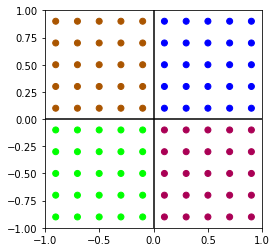

In [70]:
fig=draw_squares(Data)

In [72]:
def measurement_squares_1q(x, y, parameters, device):
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5)
    C = QuantumCircuit(3,1)
    theta = 2 * np.arccos(1/np.sqrt(3))
    if y == 1:
        C.u3(theta, 0, 0, 1)
    elif y == 2:
        C.u3(theta, 2 * np.pi / 3, 0, 1)
    elif y == 3:
        C.u3(theta, -2 * np.pi / 3, 0, 1)

    C.h(2)
    for l in range(layers):
        C.u3(parameters[l,0] * x[0] + parameters[l, 1], parameters[l, 2] * x[1] + parameters[l, 3], parameters[l, 4], 0)

    C.cswap(2, 0, 1)
    C.h(2)

    C.measure([2], [0])
    C.draw()
    # Select the QasmSimulator from the Aer provider
    try:
        backend = Aer.get_backend(device)
    except:
        provider = IBMQ.get_provider()#hub='ibm-q')
        backend=provider.get_backend(dev)

    # Execute and get counts
    sh = 1024
    result = execute(C, backend, shots=sh).result()
    counts = result.get_counts(C)
    fidelity = 2 * counts['0'] / sh - 1
    return fidelity

def check_squares_1q(x, parameters, device):
    Fidelities = np.zeros(4)
    for y in range(4):
        Fidelities[y] = measurement_squares_1q(x, y, parameters, device)
    #for y in range(2):
        #Fidelities[y] = measurement_circle(x, y, parameters, device)
        
    return Fidelities

In [73]:
def cost_function_squares_1q(parameters, X, Y, device):
        chi2 = 0
        for x, y in zip(X, Y):
            chi2 += (1 - measurement_squares_1q(x, y, parameters, device))**2
            
        return chi2 / len(Y)

In [74]:
dev = 'qasm_simulator'

In [75]:
layers=2
from scipy.optimize import minimize
parameters = np.random.rand(5*layers)

solution2 = minimize(cost_function_squares_1q,parameters, args=(Data[0], Data[1], dev), method='Powell')

solution2

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: array(0.04597565)
 message: 'Optimization terminated successfully.'
    nfev: 641
     nit: 4
  status: 0
 success: True
       x: array([ -0.61223406,   0.91409668,   2.99037948,  -0.27376954,
       -18.00018735,  -1.65482096,   1.87827149,   1.28176059,
         1.03194333,   2.18032859])

In [ ]:
layers=2
sol2=np.array([ -0.61223406,   0.91409668,   2.99037948,  -0.27376954,
       -18.00018735,  -1.65482096,   1.87827149,   1.28176059,
         1.03194333,   2.18032859])

In [76]:
layers=3
from scipy.optimize import minimize
parameters = np.random.rand(5*layers)

solution3 = minimize(cost_function_squares_1q,parameters, args=(Data[0], Data[1], dev), method='Powell')

solution3

   direc: array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.

In [ ]:
layers=3
sol3 = np.array([-1.37613260e+00,  1.43860180e+00,  1.86205057e+00,  3.02632240e-01,
        1.82343450e+00, -1.80268059e-01, -3.59696883e-01,  7.61338858e-01,
       -3.52744050e-01, -1.01347333e+00,  1.25226458e-01,  1.22540147e+00,
       -1.32961154e-01,  2.52318725e-03, -1.13775081e+01])

In [77]:
layers=4
from scipy.optimize import minimize
parameters = np.random.rand(5*layers)

solution4 = minimize(cost_function_squares_1q,parameters, args=(Data[0], Data[1], dev), method='Powell')

solution4

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000

In [ ]:
layers=4
sol4=np.array([ 1.30895602, -0.57565559,  1.00436001,  0.6156453 , 12.66044441,
        0.53873896,  1.07309675,  1.12830933,  0.96267397, 19.17301961,
       -3.04871161,  0.98115036,  0.39425071,  0.13637365, -1.99984761,
        2.72477767,  0.47630155,  0.56646784, -0.87136844, -9.76998018])

In [78]:
layers=5
from scipy.optimize import minimize
parameters = np.random.rand(5*layers)

solution5 = minimize(cost_function_squares_1q,parameters, args=(Data[0], Data[1], dev), method='Powell')

solution5

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e

In [ ]:
layers=5
sol5=np.array([-3.01641374,  1.55478557, -0.32872145,  1.57622869,  0.78678545,
       -0.5483495 , -0.36174715,  0.65016051,  0.81060793, 10.22910584,
       -1.32908903,  1.00070171,  0.60270373,  1.35620825,  8.53940776,
        0.31431818,  0.39332703,  1.24500151,  0.29888259, -0.20825896,
       -1.01827388,  1.45569664,  0.37430658, -0.14085611, -7.36910623])

In [32]:
def measurement_check(x, parameters, device):
    fidelities = np.empty(4)
    for _ in range(4):
        fidelities[_]=measurement_4classes_1qubit(x, _, parameters, device)
        
    return np.argmax(fidelities)

In [33]:
optimal_parameters=solution.x
optimal_parameters

array([-0.52847384, -0.55359746,  2.74268007, -1.15787249,  8.53845536,
        2.08627036, -0.64925619, -1.12884179,  0.03602667,  6.30021328])

In [29]:
optimal_parameters=np.array([-0.52847384, -0.55359746,  2.74268007, -1.15787249,  8.53845536,
        2.08627036, -0.64925619, -1.12884179,  0.03602667,  6.30021328])

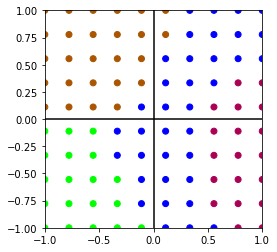

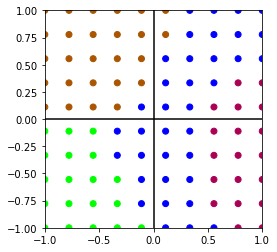

In [35]:
#grid

grid = 10
x = np.linspace(-1,1,grid)
X = list(itertools.product(x, x))
X = np.asfarray(X)
Z = np.empty(len(X))
for i, x in enumerate(X):
    Z[i]=measurement_check(x, optimal_parameters, dev)
    
fig=draw_squares((X,Z))

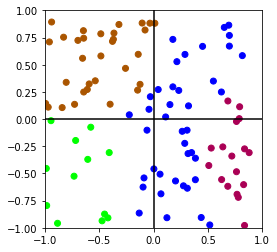

In [44]:
test = 100
X = 1.9 * np.random.rand(test, 2) - 1
F = np.empty(test)
for i, x in enumerate(X):
    F[i] = measurement_check([x[0], x[1]], optimal_parameters, dev)
    
fig=draw_squares((X, F), colorbar=False)


In [58]:
from qiskit import IBMQ
IBMQ.load_account()
dev='ibmq_vigo'

In [61]:
from qiskit import IBMQ
dev='ibmq_vigo'
def measurement_4classes_1qubitQ(x, y, parameters, device):
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5)
    C = QuantumCircuit(3,1)
    theta = 2 * np.arccos(1/np.sqrt(3))
    if y == 1:
        C.u3(theta, 0, 0, 1)
    elif y == 2:
        C.u3(theta, 2 * np.pi / 3, 0, 1)
    elif y == 3:
        C.u3(theta, -2 * np.pi / 3, 0, 1)

    C.h(2)
    for l in range(layers):
        C.u3(parameters[l,0] * x[0] + parameters[l, 1], parameters[l, 2] * x[1] + parameters[l, 3], parameters[l, 2], 0)

    C.cswap(2, 0, 1)
    C.h(2)

    C.measure([2], [0])
    C.draw()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend=provider.get_backend(device)

    # Execute and get counts
    sh = 1024
    result = execute(C, backend, shots=sh).result()
    counts = result.get_counts(C)
    fidelity = 2 * counts['0'] / sh - 1
    return fidelity


def measurement_checkQ(x, parameters, device):
    fidelities = np.empty(4)
    for _ in range(4):
        fidelities[_]=measurement_4classes_1qubitQ(x, _, parameters, device)
        
    return np.argmax(fidelities)

In [63]:
test = 50
X = 1.9 * np.random.rand(test, 2) - 1
Fq = np.empty((test, 4))

for i, x in enumerate(X):
    F[i] = measurement_checkQ([x[0], x[1]], optimal_parameters, dev)
    

KeyboardInterrupt: 

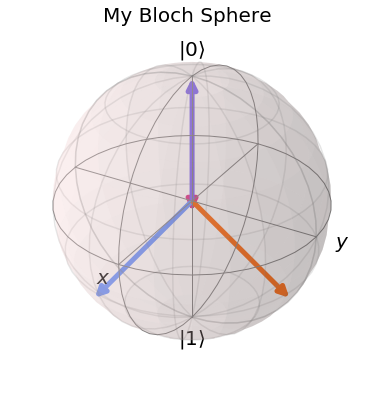

In [58]:
from qiskit.visualization import plot_bloch_vector
psi0=[0,0,1]
psi1=[0,np.sqrt(2/3),-1/np.sqrt(3)]
psi2=[1/np.sqrt(2),-np.sqrt(1/6),-1/np.sqrt(3)]
psi3=[-1/np.sqrt(2),-np.sqrt(1/6),-1/np.sqrt(3)]
plot_bloch_vector([psi3, psi2, psi1, psi0], title="My Bloch Sphere")

In [32]:
help(plot_bloch_vector)

Help on function plot_bloch_vector in module qiskit.visualization.state_visualization:

plot_bloch_vector(bloch, title='', ax=None, figsize=None)
    Plot the Bloch sphere.
    
    Plot a sphere, axes, the Bloch vector, and its projections onto each axis.
    
    Args:
        bloch (list[double]): array of three elements where [<x>, <y>, <z>]
        title (str): a string that represents the plot title
        ax (matplotlib.Axes): An Axes to use for rendering the bloch sphere
        figsize (tuple): Figure size in inches. Has no effect is passing `ax`.
    
    Returns:
        Figure: A matplotlib figure instance if `ax = None`.
    
    Raises:
        ImportError: Requires matplotlib.



In [46]:
from qiskit.visualization.interactive import iplot_bloch_multivector
psi0=np.array([1,0])
psi1=1/np.sqrt(2)*np.array([1,1])
iplot_bloch_multivector(psi0)
iplot_bloch_multivector(psi1)